In [1]:
# Numerical computing
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, Image

# Machine learning utilities
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### The Big Problem

Natural light from the ocean surface diminishes rapidly with depth. The twilight zone begins around 200 meters and extends down to the midnight zone at roughly 1,000 meters. In these low-light environments, many creatures evolve larger eyes to maximize photon capture, and even below 1,000 meters, some species continue to use light, often bioluminescent, to attract prey.

Some examples include:

1. Bigeye Tuna (Thunnus obesus), which can reach ~400 m. Evidence suggests they can be drawn toward artificial light more strongly than other species.
2. Swordfish (Xiphias gladius), reaching ~550 m. Their vision is highly adapted to low-light environments.
3. Giant Pacific Octopus (Enteroctopus dofleini), down to ~800 m. Octopuses can detect light even on their arms and will often withdraw when illuminated.
4. Zooplankton, which are strongly attracted to light. ROV lights frequently gather clouds of zooplankton, altering the local ecosystem and affecting predator-prey interactions.
5. Hatchetfish (Sternoptychidae), down to ~1,300 m. Their upward-facing eyes are specialized to detect shadows and silhouettes from above.

This highlights a key challenge for observing deep-sea creatures: how can we monitor them without disturbing their natural behavior? Currently, cameras and artificial lighting are the primary tools for recording movement, but these almost certainly induce abnormal behavior in many species. Some individuals may approach the light, while others are repelled.

### A Plausible Alternative: Acoustics

One potential solution is to use acoustic monitoring. Hydrophones can detect the sounds and movements of creatures without the need for light. However, a single hydrophone provides limited information underwater: sound attenuates and scatters rapidly, and signals are convolved by the medium. Unlike on land, where a microphone might allow rough species identification, underwater observation typically requires an array of hydrophones to reconstruct spatial information.

Imagine a scenario in which a creature moves within a medium surrounded by hydrophones. By recording the pressure signals over time at multiple positions, we can ask:

What can be inferred about the creature’s movement?

What can be inferred about its morphology or size?

With a limited number of hydrophones, exact reconstruction of detailed behavior may be impossible. Nonetheless, it may still be feasible to classify creatures into distinct types, which is valuable for population monitoring, conservation, and ecological studies.

### The Research Question

Can deep-sea creatures be plausibly classified using only hydrophone recordings?
In other words, is it possible to perform reliable population studies in environments where visual observation is infeasible or disruptive?

### Setting Up a Simulation

To explore this question, we can start with a simplified simulation:

A two-dimensional space

An array of hydrophones

A moving creature represented as a set of dynamic acoustic sources

The first step is to create a function that generates the microphone array, which will serve as the foundation for simulating acoustic recordings.

In [2]:
# Create microphones placed along the edges of a square grid
def make_mics(size=100, step=10):
    return np.array(
        [[0, i] for i in range(0, size, step)] +
        [[i, size] for i in range(0, size, step)] +
        [[size-i, 0] for i in range(0, size, step)] +
        [[size, size-i] for i in range(0, size, step)]
    )

We can visualize this

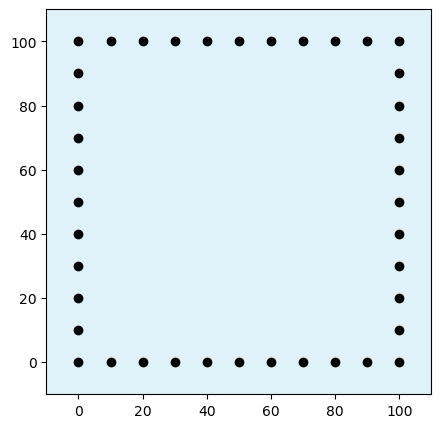

In [3]:
mics = make_mics()
fig, ax = plt.subplots(figsize=(5,5))
ax.set_facecolor("#dff1f9")
ax.scatter(mics[:,0], mics[:,1], color="black")
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)
ax.set_aspect("equal")
plt.show()

Now let's define two types of creatures:

1. A box which rotates and moves linearly with small random directional changes and rotates in place.
2. A worm which moves linearly and has a wavy “body” that oscillates over time.

In [4]:
# Useful function to rotate a set of points around a given center by theta radians
def rotate(points, theta, center):
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta),  np.cos(theta)]])
    return (points - center) @ R.T + center

class BoxCreature:
    def __init__(self):
        self.center = np.random.uniform(20, 80, size=2)
        self.rotation_speed = np.random.uniform(0.05, 0.2)
        angle = np.random.uniform(0, 2*np.pi)
        self.direction = np.array([np.cos(angle), np.sin(angle)])
        self.move_speed = np.random.uniform(0.05, 0.3)

    def __call__(self, t):
        self.center += self.direction * self.move_speed
        self.direction += 0.01 * (np.random.rand(2) - 0.5)
        self.direction /= np.linalg.norm(self.direction)
        theta = self.rotation_speed * t
        points = np.array([
            [-10, -10],
            [-10,  10],
            [10, -10],
            [10, 10],
        ]) + self.center
        return rotate(points, theta, self.center)

class WormCreature:
    def __init__(self):
        self.center = np.random.uniform(20, 80, size=2)
        angle = np.random.uniform(0, 2*np.pi)
        self.direction = np.array([np.cos(angle), np.sin(angle)])
        self.move_speed = np.random.uniform(0.05, 0.3)
        self.wave_speed = np.random.uniform(0.1, 0.3)

    def __call__(self, t):
        self.center += self.direction * self.move_speed
        self.direction += 0.01 * (np.random.rand(2) - 0.5)
        self.direction /= np.linalg.norm(self.direction)
        x = np.linspace(-20, 20, 10)
        y = 3 * np.sin(0.3 * x + self.wave_speed * t)
        points = np.stack([x, y], axis=1) + self.center
        return points

We can now visualize a creature in this environment

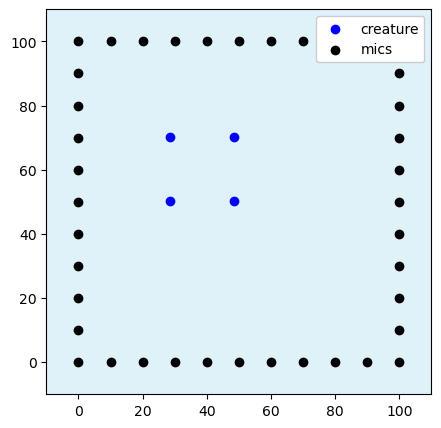

In [5]:
mics = make_mics()
creature = BoxCreature()
creature_points = creature(t=0)
fig, ax = plt.subplots(figsize=(5,5))
ax.set_facecolor("#dff1f9")
ax.scatter(creature_points[:,0], creature_points[:,1], color="blue", label="creature")
ax.scatter(mics[:,0], mics[:,1], color="black", label="mics")
ax.set_xlim(-10, 110)
ax.set_ylim(-10, 110)
ax.set_aspect("equal")
ax.legend(loc="upper right", framealpha=1)
plt.show()

We need some functions to get the signal each microphone receives, and the ability to get the creature's trajectory over time as it moves.

In [6]:
def mic_signal(points, mics, eps=1e-3):
    dists = np.linalg.norm(points[:, None, :] - mics[None, :, :], axis=2)
    return np.sum(1 / (dists + eps), axis=0)

def generate_trajectory(creature_fn, num_steps=100):
    traj = np.stack([creature_fn(t) for t in range(num_steps)])
    return traj

def generate_mic_data_from_traj(traj, mics, normalize=True):
    num_steps = traj.shape[0]
    signals = np.zeros((len(mics), num_steps))

    for t in range(num_steps):
        signals[:, t] = mic_signal(traj[t], mics)

    if normalize:
        signals /= signals.max()

    return signals

We can also make an animation as the creature moves, using the size of the microphones to represent the signal:

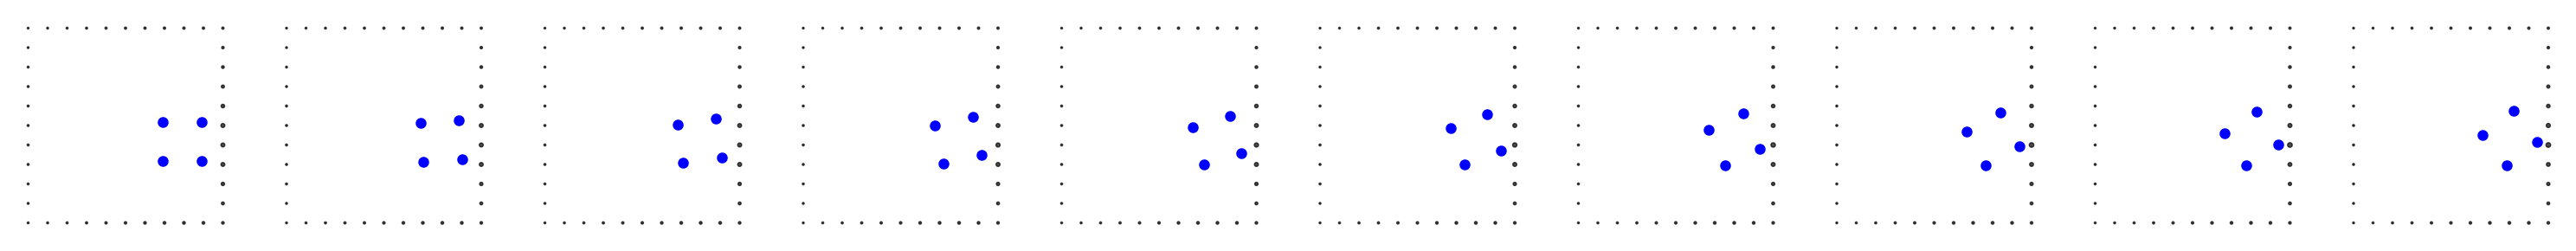

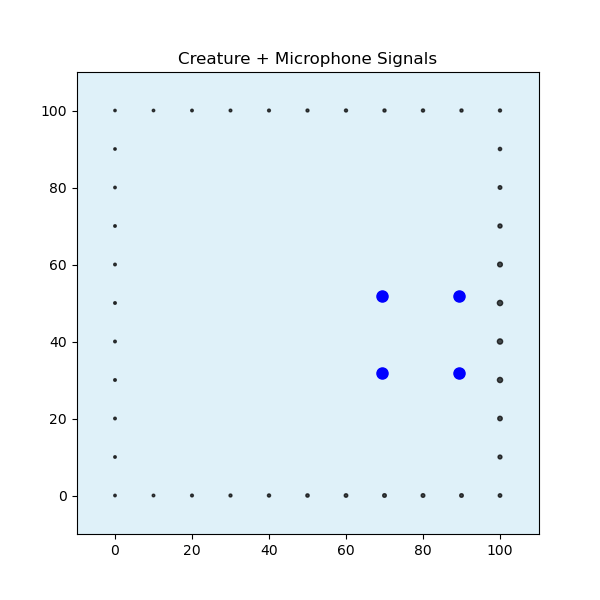

In [7]:
def animate_creature(traj, mics, signals, interval=50, save_path="creature.gif", preview_frames=10):
    num_steps = traj.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-10, 110)
    ax.set_ylim(-10, 110)
    ax.set_aspect('equal')
    ax.set_facecolor("#dff1f9")
    ax.set_title("Creature + Microphone Signals")

    creature_plot, = ax.plot(traj[0,:,0], traj[0,:,1], 'bo', ms=8)
    mic_plot = ax.scatter(mics[:,0], mics[:,1], s=300*signals[:,0], c='black', alpha=0.7)

    def update(t):
        creature_plot.set_data(traj[t,:,0], traj[t,:,1])
        mic_plot.set_sizes(400 * signals[:,t])
        return creature_plot, mic_plot

    ani = FuncAnimation(fig, update, frames=num_steps, interval=interval, blit=True)
    ani.save(save_path, writer=PillowWriter(fps=1000//interval))
    plt.close(fig)

    fig_preview, axes = plt.subplots(1, preview_frames, figsize=(preview_frames * 3, 3))
    if preview_frames == 1:
        axes = [axes]

    for i in range(preview_frames):
        axp = axes[i]
        axp.set_xlim(-10, 110)
        axp.set_ylim(-10, 110)
        ax.set_facecolor("#dff1f9")
        axp.set_aspect('equal')
        axp.set_facecolor("#dff1f9")
        axp.scatter(mics[:,0], mics[:,1], s=300*signals[:,i], c='black', alpha=0.7)
        axp.plot(traj[i,:,0], traj[i,:,1], 'bo', ms=8)
        axp.axis('off')
        
    plt.tight_layout()
    plt.show()

mics = make_mics()
creature = BoxCreature()
traj = generate_trajectory(creature, num_steps=100)
signals = generate_mic_data_from_traj(traj, mics)
animate_creature(traj, mics, signals, save_path="box_creature.gif")
display(Image(filename="box_creature.gif"))

And we can also see those values over time as a line plot too:

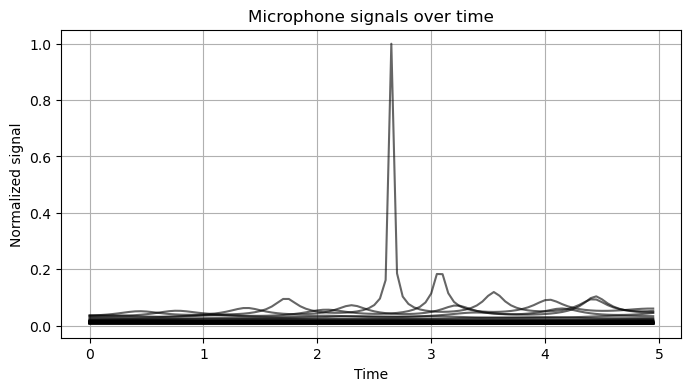

In [8]:
def plot_mic_timeseries(signals, dt=0.05):
    t = np.arange(signals.shape[1]) * dt
    plt.figure(figsize=(8, 4))
    for i in range(signals.shape[0]):
        plt.plot(t, signals[i], alpha=0.6, color="black")
    plt.xlabel("Time")
    plt.ylabel("Normalized signal")
    plt.title("Microphone signals over time")
    plt.grid(True)
    plt.show()

plot_mic_timeseries(signals)

For completeness, let's do the same for the worm

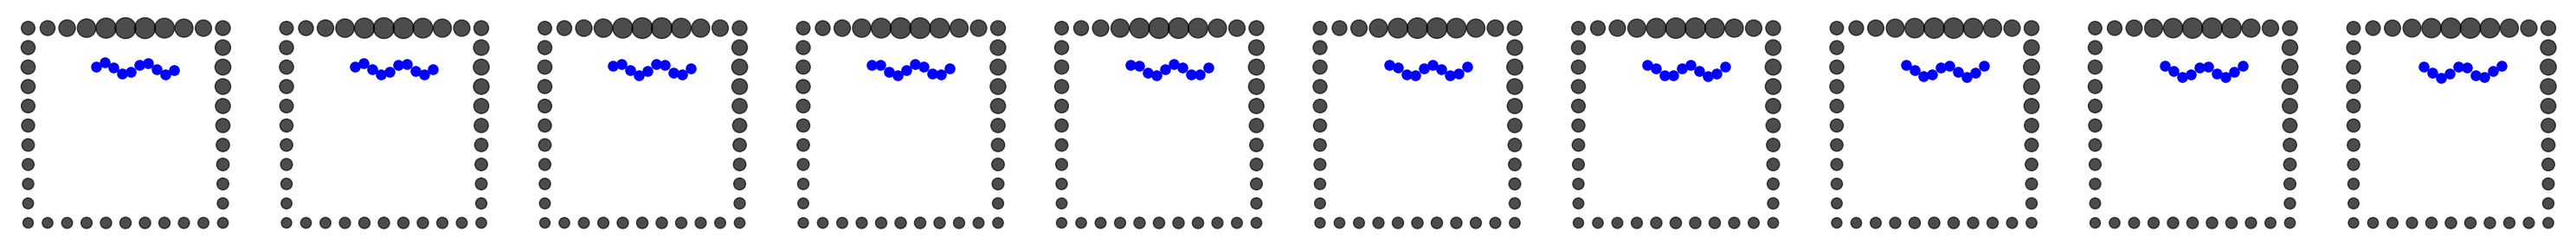

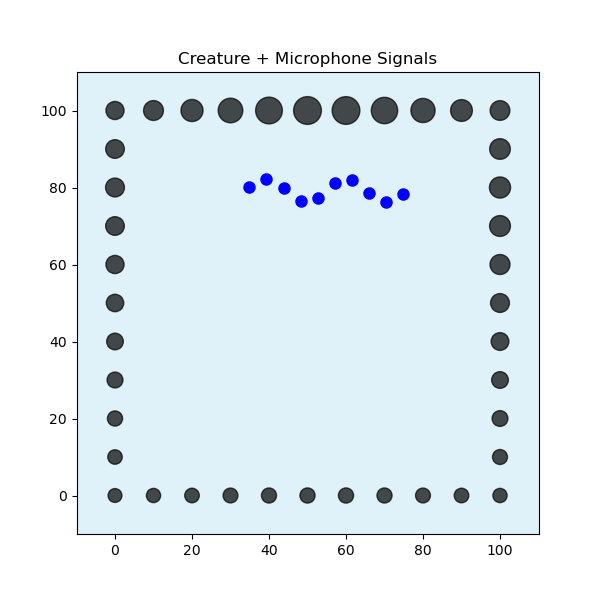

In [9]:
mics = make_mics()
creature = WormCreature()
traj = generate_trajectory(creature, num_steps=100)
signals = generate_mic_data_from_traj(traj, mics)
animate_creature(traj, mics, signals, save_path="worm_creature.gif")
display(Image(filename="worm_creature.gif"))

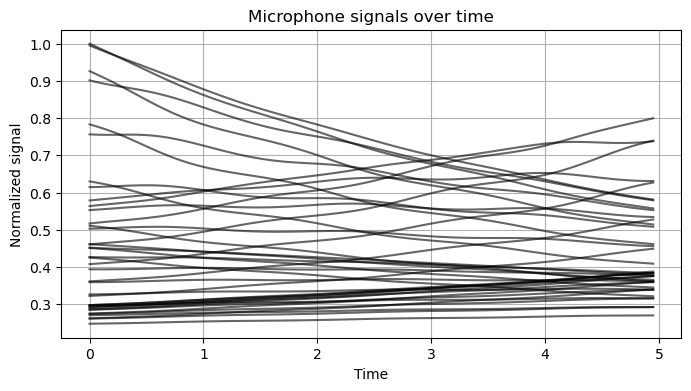

In [10]:
plot_mic_timeseries(signals)

### Machine learning bit

Now I want to perform classification of the creatures, given the recordings. 

Here I'll generate 500 examples of each class, with 100 timesteps each.

In [11]:
box_signals = []
worm_signals = []
for i in range(500):
    box_signals.append(generate_mic_data_from_traj(generate_trajectory(BoxCreature(), num_steps=100), mics))
    worm_signals.append(generate_mic_data_from_traj(generate_trajectory(WormCreature(), num_steps=100), mics))
box_signals = np.array(box_signals)
worm_signals = np.array(worm_signals)
X = np.concatenate([box_signals,worm_signals])
y = np.concatenate([np.zeros(len(box_signals)), np.ones(len(worm_signals))])
X = X.reshape(len(X),-1) # The data is (N, M, T) where M is the number of mics and T is the number of timesteps.

Turning the data into tensors, datasets, and then creating a small network in pytorch...

In [12]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

And now we can train!

Epoch 0: Train Acc=0.534, Test Acc=0.495
Epoch 10: Train Acc=0.556, Test Acc=0.580
Epoch 20: Train Acc=0.607, Test Acc=0.585
Epoch 30: Train Acc=0.652, Test Acc=0.665
Epoch 40: Train Acc=0.715, Test Acc=0.690
Epoch 50: Train Acc=0.759, Test Acc=0.725
Epoch 60: Train Acc=0.862, Test Acc=0.830
Epoch 70: Train Acc=0.918, Test Acc=0.900
Epoch 80: Train Acc=0.939, Test Acc=0.920
Epoch 90: Train Acc=0.932, Test Acc=0.905


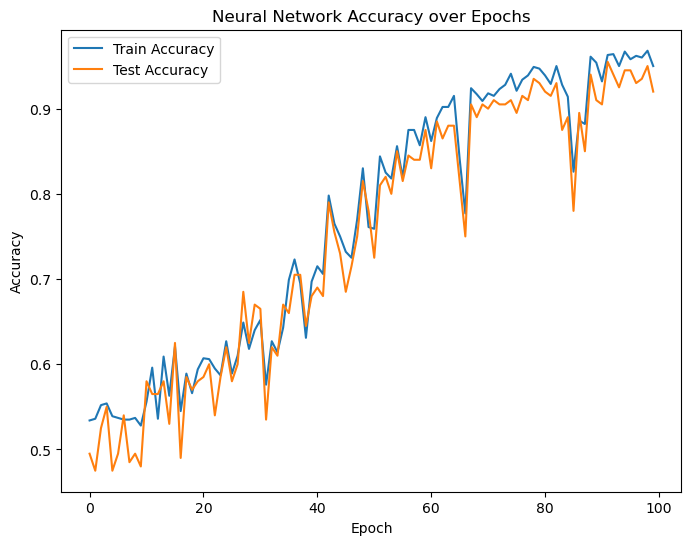

In [13]:
model = SimpleNet(input_dim=X.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 100
train_acc_list = []
test_acc_list = []

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        train_pred = (model(X_tensor) > 0.5).float()
        train_acc = (train_pred == y_tensor).float().mean().item()
        
        test_X = torch.tensor(X[test_dataset.indices], dtype=torch.float32)
        test_y = torch.tensor(y[test_dataset.indices], dtype=torch.float32).unsqueeze(1)
        test_pred = (model(test_X) > 0.5).float()
        test_acc = (test_pred == test_y).float().mean().item()
    
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Acc={train_acc:.3f}, Test Acc={test_acc:.3f}")

plt.figure(figsize=(8,6))
plt.plot(train_acc_list, label="Train Accuracy")
plt.plot(test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Neural Network Accuracy over Epochs")
plt.legend()
plt.show()

And we can see even this simple network learns to somewhat distinguish between the creatures, fantastic. As a consequence you can imagine a system for monitoring deep-sea creature without light, and, as an added bonus, it requires minimal energy when compared to visual systems, making it more suitable for long-term deployment.

### Extensions

There are several challenges to applying this approach in real-world settings:
1. **Obtaining training labels:** Collecting labeled data requires observing the creatures, which is precisely the problem we are trying to solve. Artificial lighting can disturb behavior, driving some animals away and attracting others, so behavior in illuminated conditions may not reflect natural movement. One possible workaround is to record acoustic data until a creature exits the test environment and then take a photograph for classification. Alternatively, one could generate synthetic training data using biologists’ observations and known species characteristics, but this would require detailed modeling of shapes and movements in a simulated deep-sea environment, an inherently complex task.
2. **Environmental noise:** Real-world oceans are noisy: currents, waves, and other organisms produce pressure fluctuations that can obscure the signals of interest. Effective filtering and signal processing would be essential.
3. **Information limitations:** Hydrophones may not capture sufficient data for accurate classification, especially in ecosystems with thousands of species.

An alternative approach is unsupervised learning, which does not rely on class labels. This could provide estimates of overall population size or even suggest the number of distinct species through signal clustering, although results will be far less useful.

### Broader Implications

More broadly, this work demonstrates that distributed acoustic measurements can contain enough information to support classification of moving sources, even when direct observation is impossible.

One potential implication is in medical and biological sensing, where distributed microphones or pressure sensors could be used to infer the presence, shape, or abnormal motion of internal structures from indirect acoustic signals. While the physical setting differs substantially, the underlying problem — classifying hidden moving sources from noisy pressure measurements using learned models — is closely related.